In [47]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from pprint import pprint
import random
import seaborn as sns
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import math
from tensorflow.keras.models import Model
import glob 
import xml.etree.ElementTree as ET
import torch

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [48]:
dataset_directory = "C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset"
annotations  = dataset_directory + "/annotations"
image_directory = "C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset/images"


In [49]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations+ "/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file'] += [os.path.basename(anno).split('.')[0]]
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [50]:
df = pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss0,without_mask,512,366,79,105,109,142
1,maksssksksss0,with_mask,512,366,185,100,226,144
2,maksssksksss0,without_mask,512,366,325,90,360,141
3,maksssksksss1,with_mask,400,156,321,34,354,69
4,maksssksksss1,with_mask,400,156,224,38,261,73


In [51]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


<Axes: xlabel='count', ylabel='name'>

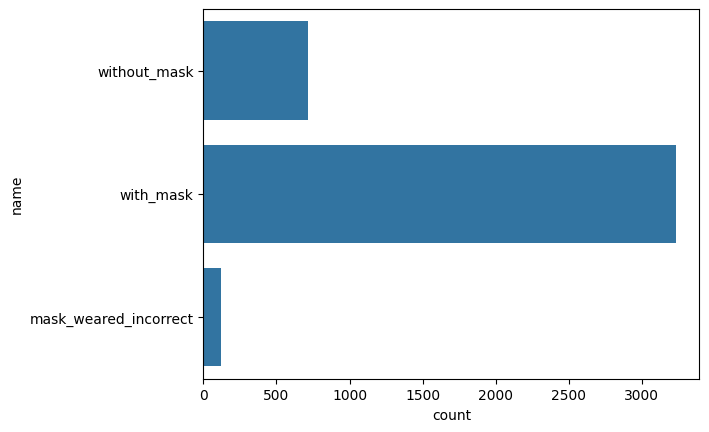

In [64]:
pprint(Counter(df['name']))
sns.countplot(df['name'])

In [53]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [54]:
with_mask_count = df[df['name'] == 'with_mask'].shape[0]
mask_weared_incorrect_count = df[df['name'] == 'mask_weared_incorrect'].shape[0]
without_mask_count = df[df['name'] == 'without_mask'].shape[0]
print(f"Number of entries with 'with_mask': {with_mask_count}")
print(f"Number of entries with 'mask_weared_incorrect': {mask_weared_incorrect_count}")
print(f"Number of entries with 'without_mask': {without_mask_count}")

Number of entries with 'with_mask': 3232
Number of entries with 'mask_weared_incorrect': 123
Number of entries with 'without_mask': 717


In [55]:
filenames = [*os.listdir(image_directory)]
print(format(len(filenames)))

853


In [99]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

# Load pre-trained SSD model (MobileNet backbone)
model = ssdlite320_mobilenet_v3_large(pretrained=True)

model.head.classification_head = torch.nn.Sequential(
    torch.nn.Conv2d(1280, 6, kernel_size=3, stride=1, padding=1)  # 3 classes: 'with_mask', 'without_mask', 'mask_weared_incorrect'
)

C:\Users\Kevem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kevem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
import os
import cv2
import torch
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
from torchvision import transforms

# Define your label mapping
label_map = {'with_mask': 0, 'without_mask': 2, 'mask_weared_incorrect': 1}

def parse_annotation(annotation_path):
    # Parse XML to extract bounding boxes and labels
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map.get(label, -1))
    
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    
    return boxes, labels

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return image

def get_data(image_folder, annotation_folder, transforms=None):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    data = []
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        annotation_path = os.path.join(annotation_folder, image_file.replace('.png', '.xml'))

        # Load image and parse annotation
        image = load_image(image_path)
        boxes, labels = parse_annotation(annotation_path)

        target = {'boxes': boxes, 'labels': labels}

        if transforms:
            image = transforms(image)

        data.append((image, target))

    return data


transform = transforms.ToTensor()

dataset = get_data(image_directory, annotations, transform)

# Example to visualize the first image and its target
image, target = dataset[0]
print(f"Boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")


Boxes: tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]])
Labels: tensor([2, 0, 2])


In [101]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [102]:
def processImage(image):
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.15, (36,255,12), 3)
        except:pass
    return image

In [103]:
if isinstance(images, list):
    images = torch.stack(images).to(device)  # Stack the list of images tensors into a single tensor and move to the device.
else:
    images = images.to(device)  # If images is already a tensor, move it to the device.

# Ensure targets are in the correct format
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to the correct device

# Forward pass: get the losses and predictions
optimizer.zero_grad()

# Ensure that model receives input in the correct format (check if the model needs any preprocessing)
loss_dict = model(images, targets)

# Compute the total loss
losses = sum(loss for loss in loss_dict.values())

# Backpropagation
losses.backward()
optimizer.step()


TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [22]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
 
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

C:\Users\Kevem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │    23,040,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,133,349 (88.25 MB)

 Trainable params: 23,133,349 (88.25 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(filenames, test_size=0.1, random_state=22)
# test, val = train_test_split(test, test_size=0.7, random_state=22)
# print("Length of Train =",len(train))
# print("="*30)
# print("Length of Valid =",len(val))
# print("="*30)
# print("Length of test =", len(test))

In [24]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001) ,metrics=['accuracy'])


In [25]:
# Initialize an empty list to collect images
image_list = []
Y = []
for index, row in df.iterrows():
    # Get the image file name and bounding box coordinates
    image_file = row['file']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    Y.append(row['class'])
    
    # Load the image
    img = cv2.imread(f'{image_directory}/{image_file}.png')
    
    # Check if the image was loaded successfully
    if img is not None:
        # Crop the image based on the bounding box
        cropped_img = img[ymin:ymax, xmin:xmax]
        
        # Resize the cropped image to the desired size (e.g., 124x124)
        resized_img = cv2.resize(cropped_img, (124, 124))
        
        # Normalize the image by dividing by 255.0
        normalized_img = resized_img / 255.0
        
        # Append the normalized image to the list
        image_list.append(normalized_img)
    else:
        print(f"Image {image_file} not found.")

# Convert the list to a numpy array
X = np.array(image_list) / 255.0
Y = np.array(Y)

# Check the shape of X
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (4072, 124, 124, 3)
Shape of Y: (4072,)


In [26]:
xtrain,xtest,ytrain,ytest=train_test_split(X, Y,train_size=0.8,random_state=0)
xtrain,xval,ytrain,yval=train_test_split(xtrain, ytrain,train_size=0.875,random_state=0)


In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [28]:
early_stop = EarlyStopping(monitor='accuracy',patience=4,mode='max')

In [29]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [30]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is configured!")
    except RuntimeError as e:
        print(e)

In [31]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=16),
                    epochs=50,
                    callbacks=[early_stop],
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50


C:\Users\Kevem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - accuracy: 0.7625 - loss: 0.6808 - val_accuracy: 0.7990 - val_loss: 0.6352
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 276ms/step - accuracy: 0.7695 - loss: 0.6263 - val_accuracy: 0.6225 - val_loss: 0.4227
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 275ms/step - accuracy: 0.6615 - loss: 0.3971 - val_accuracy: 0.6373 - val_loss: 0.2610
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.6430 - loss: 0.2601 - val_accuracy: 0.6324 - val_loss: 0.2076
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 275ms/step - accuracy: 0.6263 - loss: 0.1636 - val_accuracy: 0.6495 - val_loss: 0.1422


In [42]:
test_loss,test_accuracy = model.evaluate(xtest, ytest)
print('Test Loss for Model: ',test_loss)
print('Test Accuracy for Model: ',test_accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6947 - loss: 0.0018  
Test Loss for Model:  0.01766052283346653
Test Accuracy for Model:  0.7104294300079346


In [33]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\Kevem\AppData\Local\Temp\ipykernel_44252\391087889.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [34]:

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\Kevem\AppData\Local\Temp\ipykernel_44252\2995523894.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [35]:
model.save("mask_prediction.h5")

In [36]:
cvNet = cv2.dnn.readNetFromCaffe('model/architecture.txt','model/weights.caffemodel')

In [37]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [38]:
def processImage(image):
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image, assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.15, (36,255,12), 3)
        except:pass
    return image